(schelling)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 种族隔离

```{index} single: Schelling Segregation Model
```

```{index} single: Models; Schelling's Segregation Model
```

## 大纲

1969年，托马斯·C·谢林开发了一个简单但引人注目的种族隔离模型 {cite}`Schelling1969`。

他的模型研究了种族混合邻里的动态变化。

就像谢林的许多工作一样，该模型显示出局部互动如何导致令人惊讶的总体结果。

它研究了一个环境，其中代理（可以认为是家庭）对同种族的邻居有相对温和的偏好。

例如，这些代理可能对混种种族的邻里感到舒适，但当他们感觉被不同种族的人“包围”时会感到不舒服。

谢林展示了以下令人惊讶的结果：在这样的环境中，混合种族的社区很可能是不稳定的，倾向于随时间崩溃。

事实上，该模型预测了高度分裂的社区，具有高水平的隔离。

换句话说，尽管人们的偏好并不特别极端，但仍会出现极端的隔离结果。

这些极端结果是因为模型中代理之间的*互动*（例如，城市中的家庭）驱动模型中的自我加强动态。

随着讲座的展开，这些想法将变得更加清晰。

为了表彰他在种族隔离和其他研究方面的工作，谢林获得了2005年诺贝尔经济科学奖（与罗伯特·奥曼共享）。

让我们从一些导入开始：

In [1]:
import matplotlib.pyplot as plt
from random import uniform, seed
from math import sqrt
import numpy as np
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 模型

在这一节中，我们将构建一个Schelling模型的版本。

### 设置

我们将介绍一个与原始Schelling模型不同的变种，但同样易于编程，并且同时捕捉到了他的主要思想。

假设我们有两种类型的人：橙色人和绿色人。

假设每种类型都有$n$个人。

这些代理人都居住在一个单位正方形上。

因此，一个代理人的位置（例如，地址）只是一个点$(x, y)$，其中$0 < x, y < 1$。

* 所有点$(x,y)$满足$0 < x, y < 1$ 的集合称为**单位正方形**
* 下面我们用$S$表示单位正方形

### 偏好

我们将说一个代理人是*快乐*的，如果她最近的10个邻居中有5个或以上是同类型的。

一个不快乐的代理人被称为*不快乐*。

例如，

* 如果一个代理人是橙色的，她最近的10个邻居中有5个是橙色的，那么她是快乐的。
* 如果一个代理人是绿色的，她最近的10个邻居中有8个是橙色的，那么她是不快乐的。

“最近”的意思是根据[欧几里得距离](https://en.wikipedia.org/wiki/Euclidean_distance)。

一个重要的点是，代理人**不**反对居住在混合区域。

如果他们的一半邻居是另一种颜色，他们完全满意。

### 行为

最初，代理们混在一起（集成）。

特别地，我们假设每个代理的初始位置是从单位正方形 $S$ 上的一个双变量均匀分布中独立抽取的。

* 首先，他们的 $x$ 坐标从 $(0,1)$ 上的均匀分布中抽取
* 然后，独立地，他们的 $y$ 坐标从同一分布中抽取。

现在，轮流通过所有代理，每个代理现在有机会留下或移动。

每个代理如果满意就留下，不满意就移动。

移动的算法如下：

```{prf:algorithm} 跳转链算法
:label: move_algo

1. 在 $S$ 中随机抽取一个位置
1. 如果在新位置上感到满意，就移动到那里
1. 否则，回到步骤 1

```

我们不断地循环通过代理，每次允许不满意的代理移动。

我们继续循环，直到没有人希望移动。

## 结果

让我们现在实现和运行这个模拟。

接下来，代理被模型化为[对象](https://python-programming.quantecon.org/python_oop.html)。

以下是它们的结构指示：

```{code-block} none
* 数据：

    * 类型（绿色或橙色）
    * 位置

* 方法：

    * 根据其他代理的位置确定是否快乐
    * 如果不快乐，移动
        * 找到一个快乐的新位置
```

让我们构建它们。

In [2]:
class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "计算自己与另一代理之间的欧几里得距离。"
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self,
                agents,                # 其他代理的列表
                num_neighbors=10,      # 视为邻居的代理数量
                require_same_type=5):  # 必须是同一类型的邻居数量
        """
            如果足够多的最近邻居是同一类型，则返回True。
        """

        distances = []

        # distances是一组对(d, agent)，其中d是代理到self的距离
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))

        # 根据距离从小到大排序
        distances.sort()

        # 提取邻居代理
        neighbors = [agent for d, agent in distances[:num_neighbors]]

        # 计算有多少邻居与自己类型相同
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "如果不快乐，随机选择新位置直到快乐。"
        while not self.happy(agents):
            self.draw_location()

In [3]:
def plot_distribution(agents, cycle_num):
    "绘制经过cycle_num轮循环后，代理分布图。"
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == 获取每种类型的位置 == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'周期 {cycle_num-1}')
    plt.show()

在这里有一段伪代码，它描述了主循环的过程，我们在这个过程中遍历每个代理，直到没有代理希望移动为止。

伪代码如下

```{code-block} none
绘制分布
while 代理还在移动
    for 每个代理 in 代理们
        给予代理机会移动
绘制分布
```

真实的代码如下

In [4]:
def run_simulation(num_of_type_0=600,
                   num_of_type_1=600,
                   max_iter=100_000,       # 最大迭代次数
                   set_seed=1234):

    # 设置种子以确保可重现性
    seed(set_seed)

    # 创建类型0代理列表
    agents = [Agent(0) for i in range(num_of_type_0)]
    # 添加类型1代理列表
    agents.extend(Agent(1) for i in range(num_of_type_1))

    # 初始化计数器
    count = 1

    # 绘制初始分布
    plot_distribution(agents, count)

    # 循环直到没有代理希望移动
    while count < max_iter:
        print('进入循环 ', count)
        count += 1
        没有人移动 = True
        for agent in agents:
            old_location = agent.location
            agent.update(agents)
            if agent.location != old_location:
                没有人移动 = False
        if 没有人移动:
            break

    # 绘制最终分布
    plot_distribution(agents, count)

    if count < max_iter:
        print(f'在 {count} 次迭代后收敛。')
    else:
        print('达到迭代上限并终止。')


让我们看一下结果。

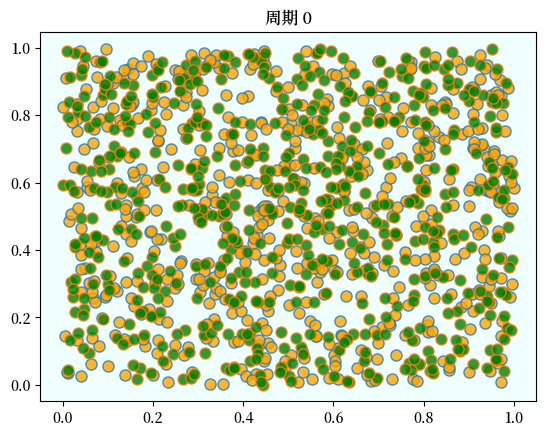

进入循环  1


进入循环  2


进入循环  3


进入循环  4


进入循环  5


进入循环  6


进入循环  7


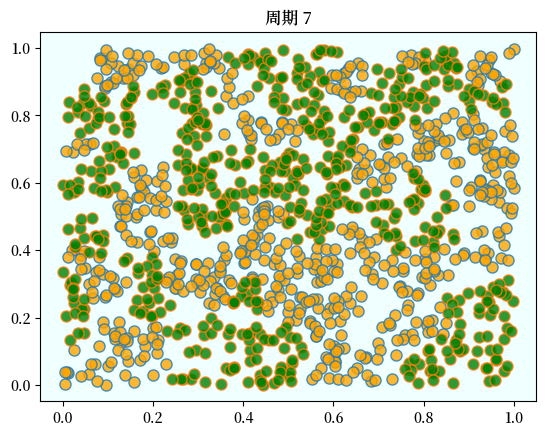

在 8 次迭代后收敛。


In [5]:
run_simulation()

如上所述，代理最初是随机混合在一起的。

但经过几轮循环后，它们变得按照不同区域分离。

在这个例子中，程序在经过一小部分代理集合的循环后终止，表明所有代理都已达到幸福状态。

图片显示的令人吃惊的现象是种族融合的迅速崩溃。

尽管实际上模型中的人并不介意和其他类型的人混居。

即使是在这些偏好下，结果依旧是高度的隔离。

## 练习

```{exercise-start}
:label: schelling_ex1
```

我们之前用到的面向对象式编程虽然整洁，但相比于过程式编程（即，围绕函数而非对象和方法的编码）更难优化。

尝试编写一个新版本的模型，存储：

* 所有代理的位置，作为一个二维的NumPy浮点数数组。
* 所有代理的类型，作为一个平面的NumPy整数数组。

编写函数，根据上述逻辑对这些数据进行操作以更新模型。

但是，实现以下两个变化：

1. 代理被随机提供移动机会（即，随机选中并给予移动的机会）。
2. 代理移动后，以0.01的概率翻转其类型。

第二个变化为模型引入了额外的随机性。

（我们可以想象，代理偶尔搬到不同的城市，并且小概率会被其他类型的代理替换。）

```{exercise-end}
```
```{solution-start} schelling_ex1
:class: dropdown
```
解决方案如下

In [6]:
from numpy.random import uniform, randint

n = 1000                # 代理人数目（代理人编号从0到n-1）
k = 10                  # 每个代理人视为邻居的代理人数
require_same_type = 5   # 希望 >= require_same_type 的邻居是相同类型

def initialize_state():
    locations = uniform(size=(n, 2))
    types = randint(0, high=2, size=n)   # 标签为零或一
    return locations, types


def compute_distances_from_loc(loc, locations):
    """ 计算位置 loc 到所有其他点的距离。 """
    return np.linalg.norm(loc - locations, axis=1)

def get_neighbors(loc, locations):
    " 获取给定位置的所有邻居。 "
    all_distances = compute_distances_from_loc(loc, locations)
    indices = np.argsort(all_distances)   # 将代理人按距离 loc 的远近排序
    neighbors = indices[:k]               # 保留最近的 k 个
    return neighbors

def is_happy(i, locations, types):
    happy = True
    agent_loc = locations[i, :]
    agent_type = types[i]
    neighbors = get_neighbors(agent_loc, locations)
    neighbor_types = types[neighbors]
    if sum(neighbor_types == agent_type) < require_same_type:
        happy = False
    return happy

def count_happy(locations, types):
    " 计算快乐代理人的数量。 "
    happy_sum = 0
    for i in range(n):
        happy_sum += is_happy(i, locations, types)
    return happy_sum

def update_agent(i, locations, types):
    " 如果代理人不快乐，则移动代理人。 "
    moved = False
    while not is_happy(i, locations, types):
        moved = True
        locations[i, :] = uniform(), uniform()
    return moved

def plot_distribution(locations, types, title, savepdf=False):
    " 绘制经过多轮循环后的代理人分布情况。"
    fig, ax = plt.subplots()
    colors = 'orange', 'green'
    for agent_type, color in zip((0, 1), colors):
        idx = (types == agent_type)
        ax.plot(locations[idx, 0],
                locations[idx, 1],
                'o',
                markersize=8,
                markerfacecolor=color,
                alpha=0.8)
    ax.set_title(title)
    plt.show()

def sim_random_select(max_iter=100_000, flip_prob=0.01, test_freq=10_000):
    """
    通过随机选择一个家庭进行更新来进行模拟。

    以概率 `flip_prob` 翻转家庭的颜色。

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter <= max_iter:

        # 选择一个随机代理人并更新其状态
        i = randint(0, n)
        moved = update_agent(i, locations, types)

        if flip_prob > 0:
            # 以概率 epsilon 翻转代理人 i 的类型
            U = uniform()
            if U < flip_prob:
                current_type = types[i]
                types[i] = 0 if current_type == 1 else 1

        # 每隔一定次数更新后，绘图并检查收敛情况
        if current_iter % test_freq == 0:
            cycle = current_iter / n
            plot_distribution(locations, types, f'迭代 {current_iter}')
            if count_happy(locations, types) == n:
                print(f"在迭代 {current_iter} 时收敛")
                break

        current_iter += 1

    if current_iter > max_iter:
        print(f"在迭代 {current_iter} 时终止")

```{solution-end}
```

当我们运行这个程序时，我们再次发现混合社区会瓦解，隔离现象会出现。

这里是一个样例运行。

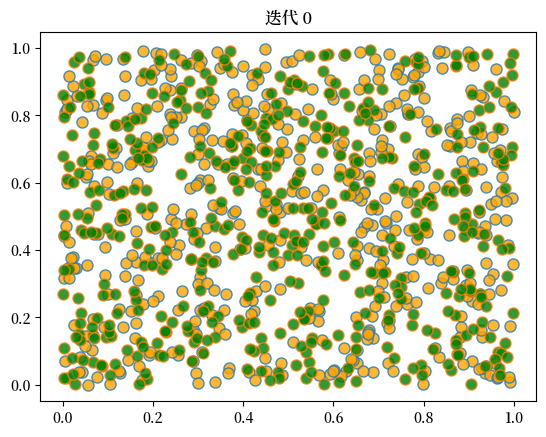

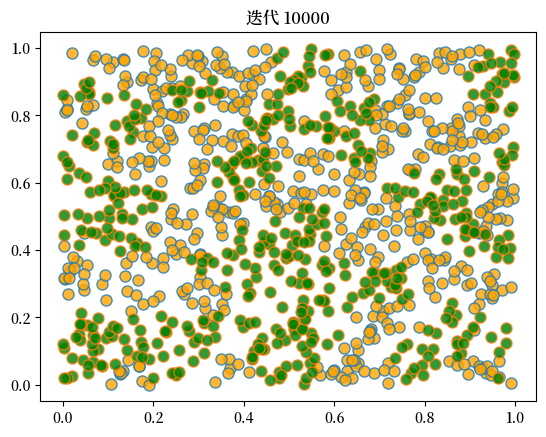

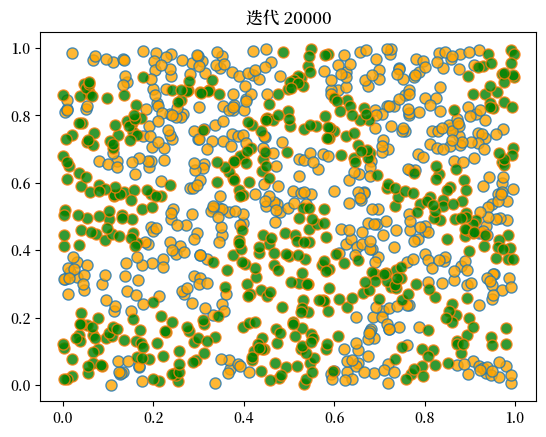

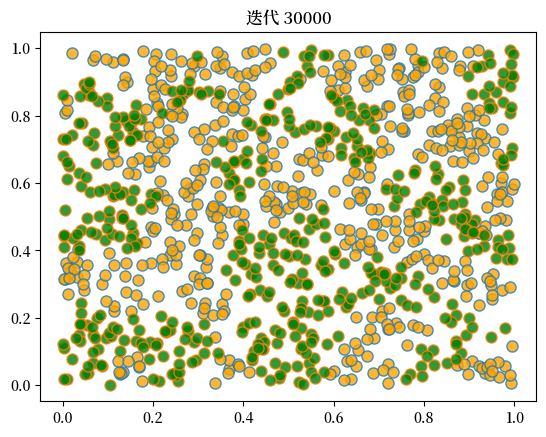

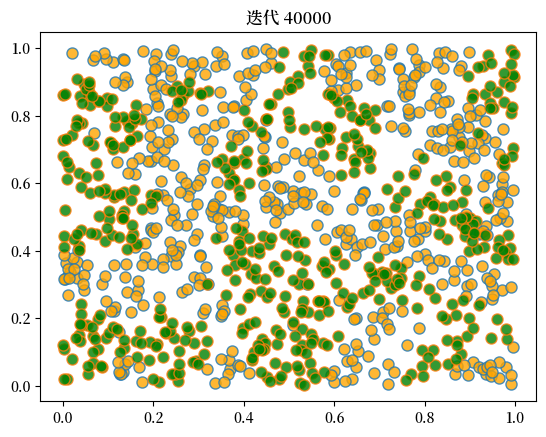

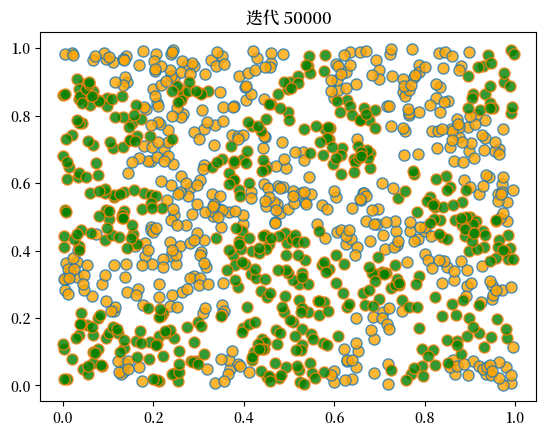

在迭代 50001 时终止


In [7]:
sim_random_select(max_iter=50_000, flip_prob=0.01, test_freq=10_000)